In [2]:
import os

# Get the current working directory
current_directory = os.getcwd()

print("Current Directory:", current_directory)


Current Directory: /Users/rorybennett


In [3]:
import pandas as pd

# Load the dataset
file_path = '/Users/rorybennett/downloads/simulated_transaction_2024.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
print(data.head())

         Date Timestamp   Account No  Balance  Amount  Third Party Account No  \
0  01/01/2023     00:00  678330503.0   2971.0  1584.0                     NaN   
1  01/01/2023     00:00  472213568.0   3792.0  1950.0                     NaN   
2  01/01/2023     00:00  472213568.0   3012.0  -780.0             283027736.0   
3  01/01/2023     00:00  283027736.0   1787.0   780.0             472213568.0   
4  01/01/2023     00:00  624500124.0   3226.0  1825.0                     NaN   

     Third Party Name  
0  Westport Care Home  
1    Barbiee Boutique  
2                 NaN  
3                 NaN  
4            Fat Face  


In [4]:
# Convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')

# For simplicity, consider only positive transaction amounts
# If negative amounts are relevant (e.g., returns), this step needs adjusting
data = data[data['Amount'] > 0]

# Determine the reference date: one day after the last transaction in the dataset
latest_date = data['Date'].max() + pd.Timedelta(days=1)

# Calculate RFM metrics
rfm = data.groupby('Account No').agg({
    'Date': lambda x: (latest_date - x.max()).days,  # Recency
    'Account No': 'count',                           # Frequency
    'Amount': 'sum'                                  # Monetary
}).rename(columns={'Date': 'Recency', 'Account No': 'Frequency', 'Amount': 'Monetary'})

# Display the calculated RFM dataframe
print(rfm.head())

             Recency  Frequency  Monetary
Account No                               
101531259.0        5         11   16967.5
104832000.0        4         14   20550.0
105375973.0        6         11    9900.0
106601471.0        5         11   18425.0
108481285.0        5         23   25104.0


In [5]:
# Scoring Recency, Frequency, and Monetary values using rank method
rfm['R_Score'] = pd.qcut(rfm['Recency'].rank(method='first'), 5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])

# Combine the RFM scores to a single score (Optional)
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Display the scored RFM dataframe
print(rfm.head())


             Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Score
Account No                                                                 
101531259.0        5         11   16967.5       4       1       2       412
104832000.0        4         14   20550.0       5       5       3       553
105375973.0        6         11    9900.0       1       1       1       111
106601471.0        5         11   18425.0       4       1       2       412
108481285.0        5         23   25104.0       4       5       4       454


In [22]:
# Define segmentation function
def assign_segment(row):
    if row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
        return 'High Value'
    elif row['R_Score'] <= 2 and row['F_Score'] <= 2 and row['M_Score'] <= 2:
        return 'At Risk'
    elif row['R_Score'] >= 4 and (row['F_Score'] <= 3 or row['M_Score'] <= 3):
        return 'Can Be Grown'
    else:
        return 'Low Value'

# Apply segmentation
rfm['Segment'] = rfm.apply(assign_segment, axis=1)

# Display the resulting segmented RFM dataframe
print(rfm.head())


             Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Score  \
Account No                                                                    
101531259.0        5         11   16967.5       4       1       2       412   
104832000.0        4         14   20550.0       5       5       3       553   
105375973.0        6         11    9900.0       1       1       1       111   
106601471.0        5         11   18425.0       4       1       2       412   
108481285.0        5         23   25104.0       4       5       4       454   

                  Segment Refined_Segment  Cluster  
Account No                                          
101531259.0  Can Be Grown       Low Value        1  
104832000.0  Can Be Grown       Low Value        1  
105375973.0       At Risk       Low Value        1  
106601471.0  Can Be Grown       Low Value        1  
108481285.0    High Value       Low Value        3  


/Users/rorybennett/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/rorybennett/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/rorybennett/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/rorybennett/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_

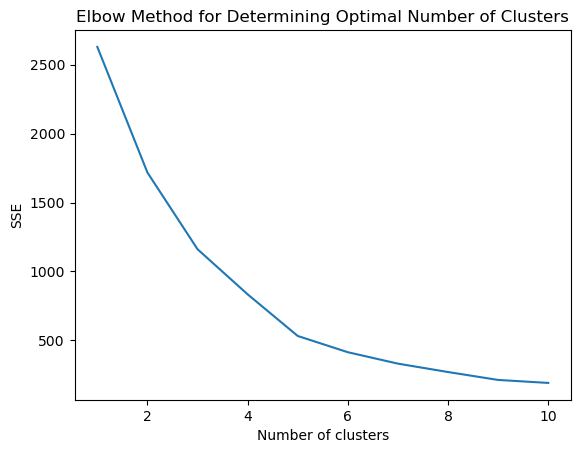

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Standardize the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Choosing the number of clusters using the elbow method
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_  # sum of squared distances to closest cluster center

# Plot SSE for each *k* to find the elbow
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("Elbow Method for Determining Optimal Number of Clusters")
plt.show()

/Users/rorybennett/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/dx/5nl8g36s7w12fygbr3_npf7c0000gn/T/ipykernel_55146/2318639283.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(rfm.groupby('Cluster').mean())


            Recency  Frequency      Monetary
Cluster                                     
0          4.702797  11.877622  36110.461958
1          7.610487  11.483146  15919.807266
2        225.187500   2.187500   2263.750000
3          4.825000  21.100000  24054.245000


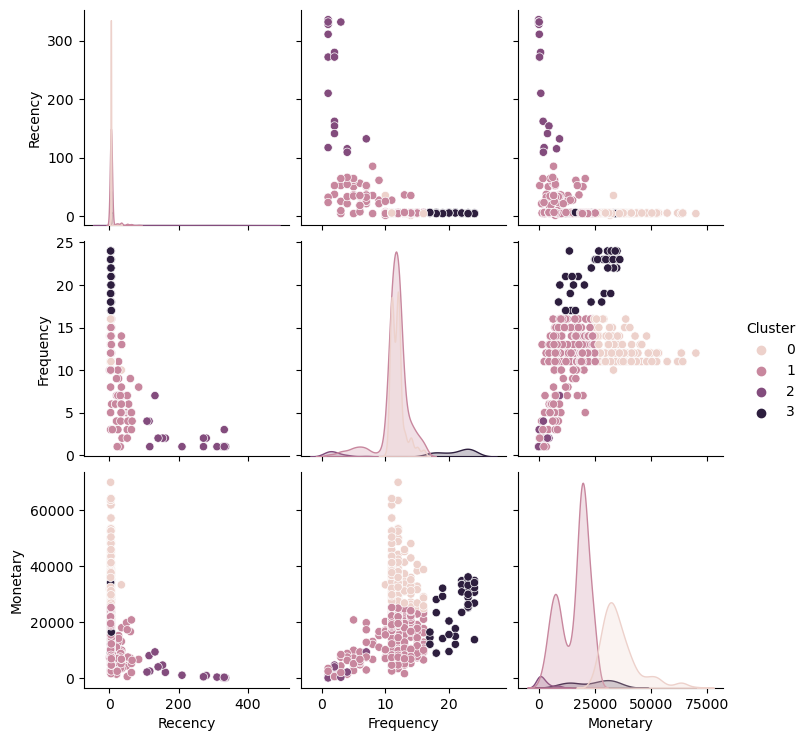

In [43]:
# Step 3: Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=1)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Step 4: Analyze the clusters
print(rfm.groupby('Cluster').mean())

# Optional: Visualizing the clusters
import seaborn as sns
sns.pairplot(rfm, hue='Cluster')
plt.show()

In [44]:
# Define marketing messages for each segment
marketing_strategies = {
    'High Value': 'Send loyalty program offers and exclusive promotions.',
    'At Risk': 'Send re-engagement campaigns with special discounts.',
    'Can Be Grown': 'Introduce new product lines and offer bundled promotions.',
    'Low Value': 'Increase engagement through general newsletters and awareness campaigns.'
}

# Apply marketing strategy to each segment
rfm['Marketing Strategy'] = rfm['Segment'].map(marketing_strategies)

# Display strategies per segment
print(rfm[['Segment', 'Marketing Strategy']].drop_duplicates())

                  Segment                                 Marketing Strategy
Account No                                                                  
101531259.0  Can Be Grown  Introduce new product lines and offer bundled ...
105375973.0       At Risk  Send re-engagement campaigns with special disc...
108481285.0    High Value  Send loyalty program offers and exclusive prom...
127809299.0     Low Value  Increase engagement through general newsletter...


In [45]:
# Generate insights based on RFM metrics
insights = {
    'High Value': 'Focus on retention, these customers are crucial for sustained revenue.',
    'At Risk': 'Identify reasons for churn, perhaps through surveys or feedback forms.',
    'Can Be Grown': 'These customers have potential, consider upselling higher-tier products.',
    'Low Value': 'Explore ways to increase transaction frequency and engagement.'
}

# Apply insights to each segment
rfm['Insights'] = rfm['Segment'].map(insights)

# Display insights per segment
print(rfm[['Segment', 'Insights']].drop_duplicates())

                  Segment                                           Insights
Account No                                                                  
101531259.0  Can Be Grown  These customers have potential, consider upsel...
105375973.0       At Risk  Identify reasons for churn, perhaps through su...
108481285.0    High Value  Focus on retention, these customers are crucia...
127809299.0     Low Value  Explore ways to increase transaction frequency...


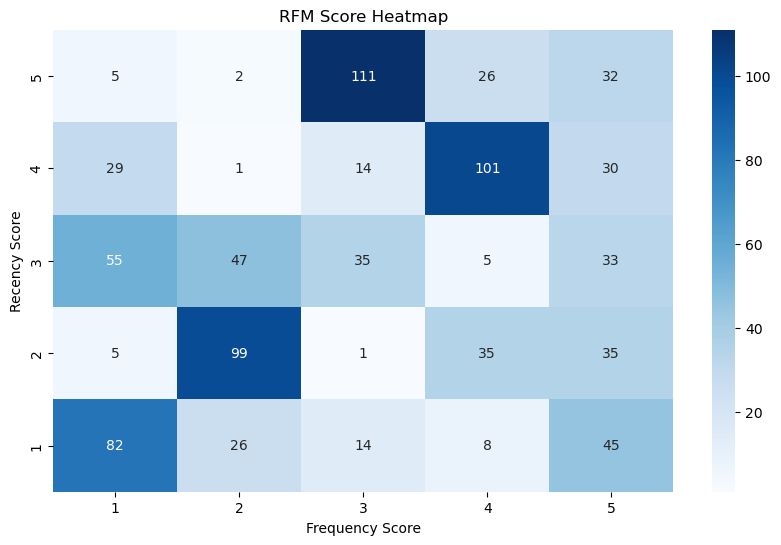

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a pivot table counting the number of customers for each RFM Score combination
rfm_pivot = rfm.pivot_table(index='R_Score', columns='F_Score', values='Monetary', aggfunc='count').fillna(0)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(rfm_pivot, annot=True, fmt=".0f", cmap='Blues')
plt.title('RFM Score Heatmap')
plt.xlabel('Frequency Score')
plt.ylabel('Recency Score')
plt.show()

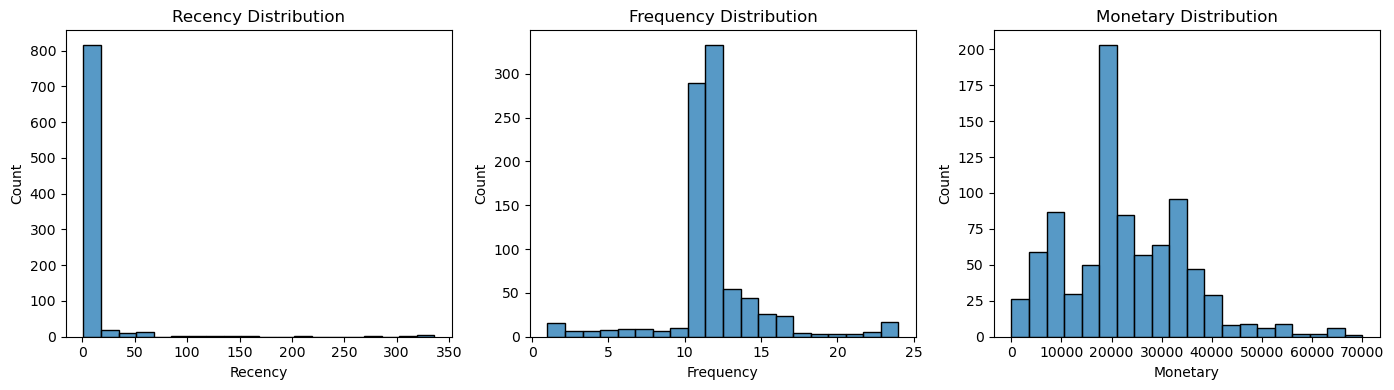

In [27]:
# Plot histograms
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], bins=20)
plt.title('Recency Distribution')

plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], bins=20)
plt.title('Frequency Distribution')

plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'], bins=20)
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()


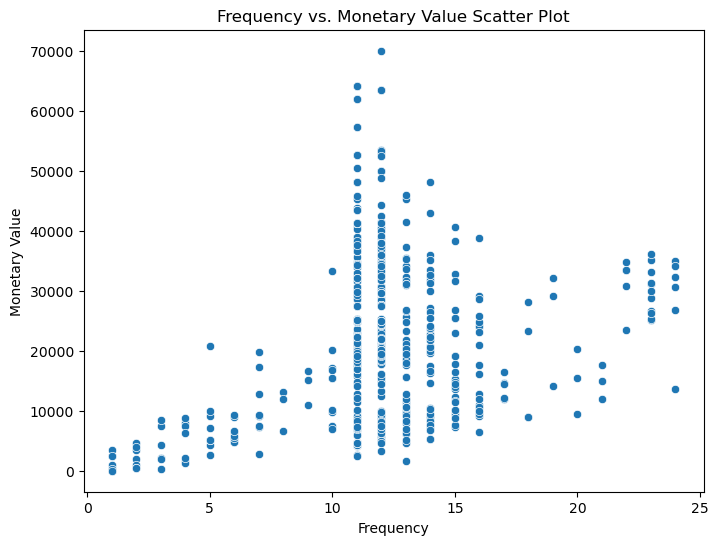

In [28]:
# Scatter plot Frequency vs Monetary
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Frequency', y='Monetary', data=rfm)
plt.title('Frequency vs. Monetary Value Scatter Plot')
plt.xlabel('Frequency')
plt.ylabel('Monetary Value')
plt.show()


/var/folders/dx/5nl8g36s7w12fygbr3_npf7c0000gn/T/ipykernel_55146/901218642.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_rfm_values = rfm.groupby('RFM_Score').mean()


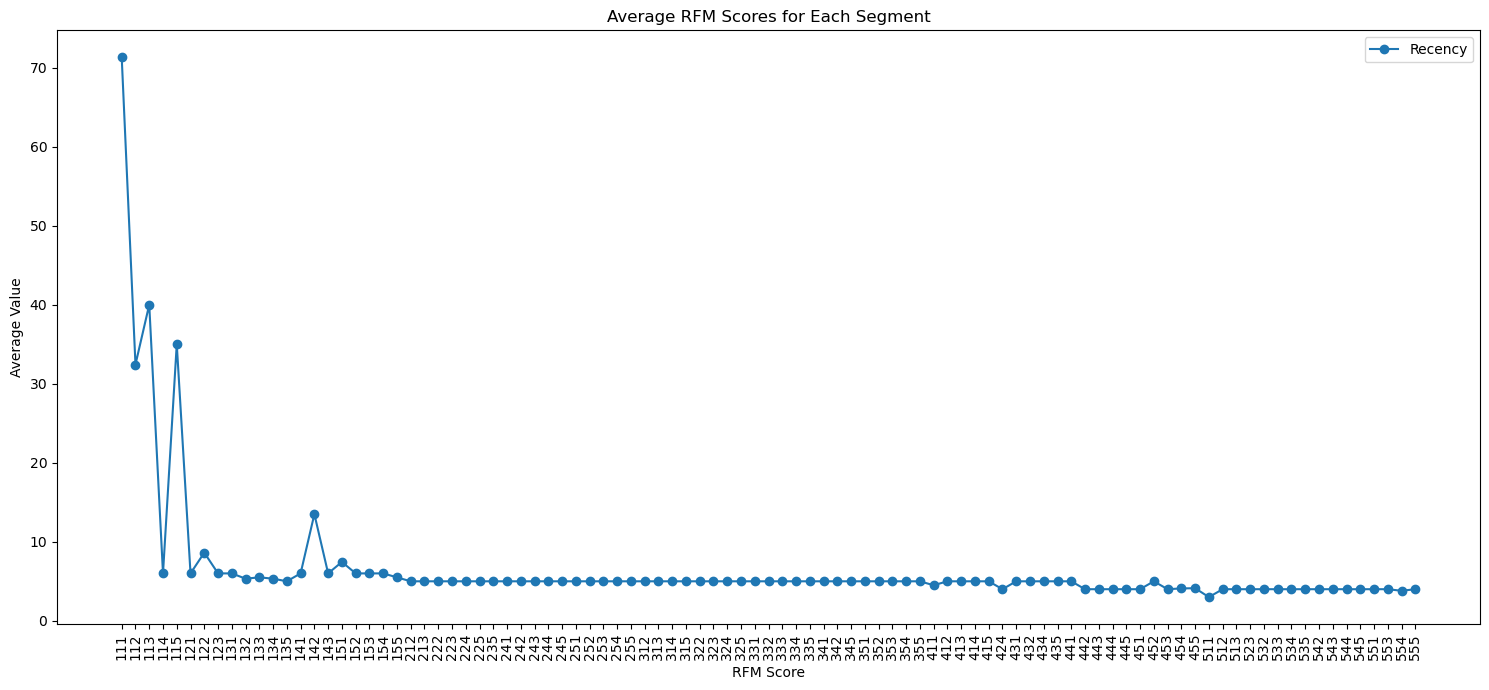

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# First, calculate the average values for each RFM_Score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
avg_rfm_values = rfm.groupby('RFM_Score').mean()

# Then, prepare the data for plotting
scores = avg_rfm_values.index.tolist()
recency_avg = avg_rfm_values['Recency']
frequency_avg = avg_rfm_values['Frequency']
monetary_avg = avg_rfm_values['Monetary']

# Create the plot
plt.figure(figsize=(15, 7))
plt.plot(scores, recency_avg, marker='o', label='Recency')

# Add titles and labels
plt.title('Average RFM Scores for Each Segment')
plt.xlabel('RFM Score')
plt.ylabel('Average Value')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust layout for better fit
plt.show()

/var/folders/dx/5nl8g36s7w12fygbr3_npf7c0000gn/T/ipykernel_55146/1386729522.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_rfm_values = rfm.groupby('RFM_Score').mean()


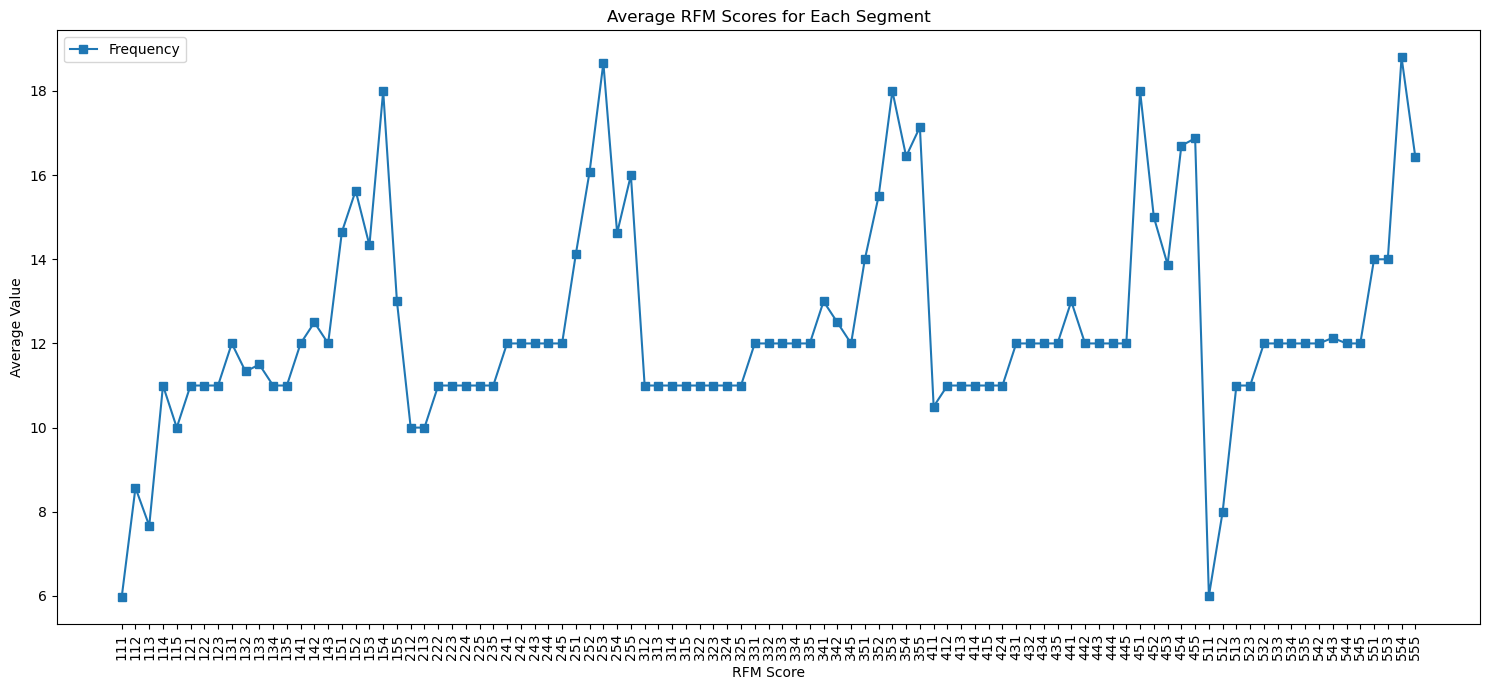

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# First, calculate the average values for each RFM_Score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
avg_rfm_values = rfm.groupby('RFM_Score').mean()

# Then, prepare the data for plotting
scores = avg_rfm_values.index.tolist()
recency_avg = avg_rfm_values['Recency']
frequency_avg = avg_rfm_values['Frequency']
monetary_avg = avg_rfm_values['Monetary']

# Create the plot
plt.figure(figsize=(15, 7))
plt.plot(scores, frequency_avg, marker='s', label='Frequency')

# Add titles and labels
plt.title('Average RFM Scores for Each Segment')
plt.xlabel('RFM Score')
plt.ylabel('Average Value')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust layout for better fit
plt.show()

/var/folders/dx/5nl8g36s7w12fygbr3_npf7c0000gn/T/ipykernel_55146/4080337599.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_rfm_values = rfm.groupby('RFM_Score').mean()


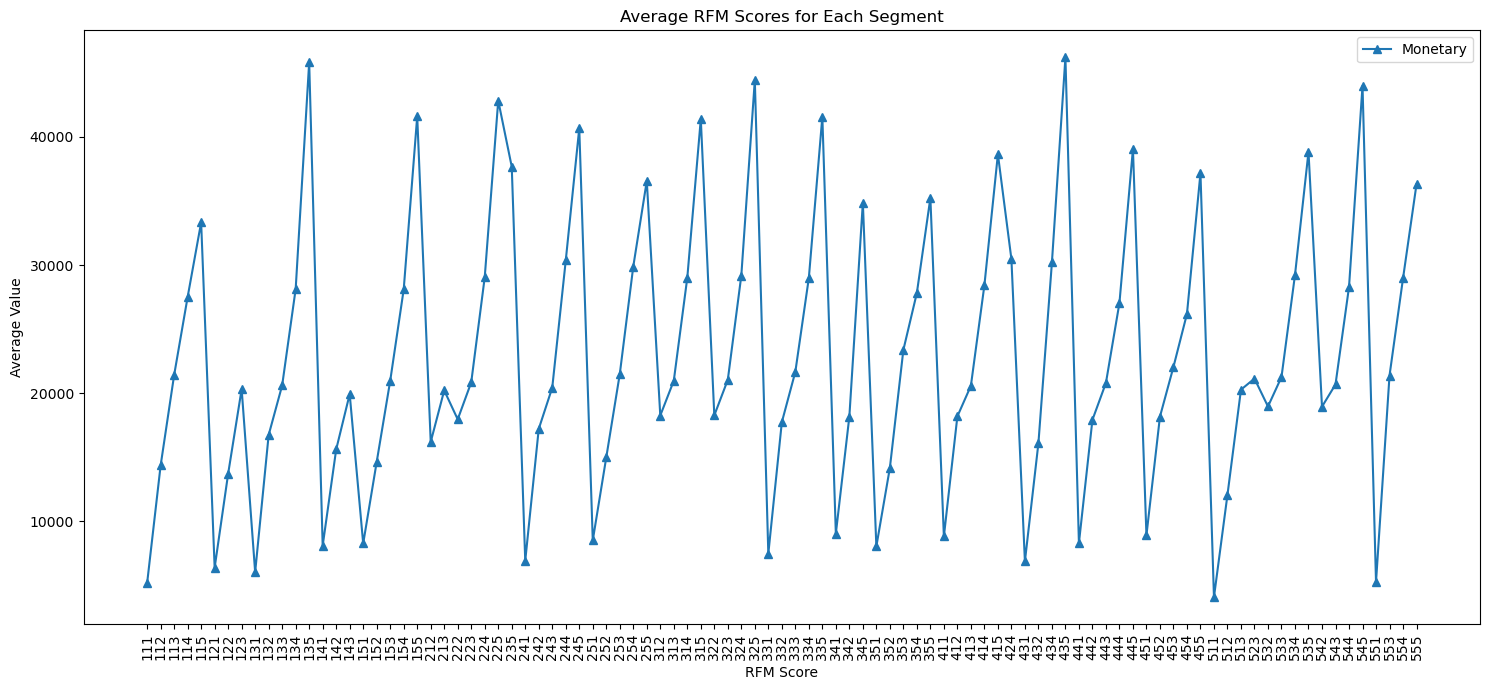

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# First, calculate the average values for each RFM_Score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
avg_rfm_values = rfm.groupby('RFM_Score').mean()

# Then, prepare the data for plotting
scores = avg_rfm_values.index.tolist()
recency_avg = avg_rfm_values['Recency']
frequency_avg = avg_rfm_values['Frequency']
monetary_avg = avg_rfm_values['Monetary']

# Create the plot
plt.figure(figsize=(15, 7))
plt.plot(scores, monetary_avg, marker='^', label='Monetary')

# Add titles and labels
plt.title('Average RFM Scores for Each Segment')
plt.xlabel('RFM Score')
plt.ylabel('Average Value')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust layout for better fit
plt.show()

/var/folders/dx/5nl8g36s7w12fygbr3_npf7c0000gn/T/ipykernel_55146/3821490705.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  segment_grouped = rfm.groupby('Refined_Segment').mean()


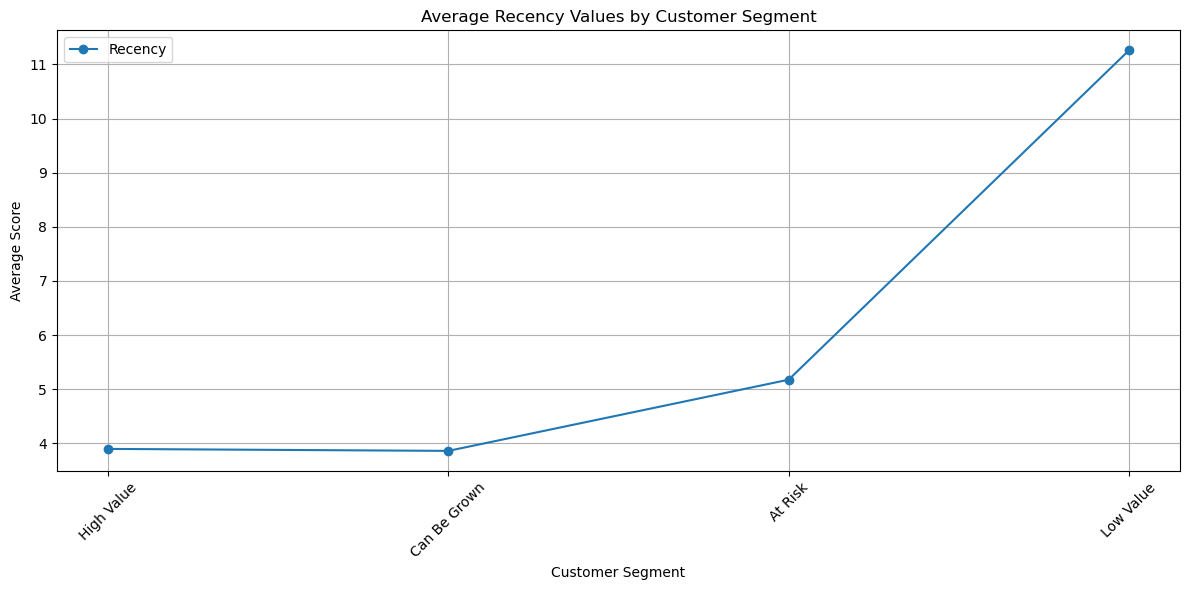

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming rfm dataframe is already defined and the segmentation function has been applied to create 'Refined_Segment'

# Calculate the average RFM values for each segment
segment_grouped = rfm.groupby('Refined_Segment').mean()

# Sort the segments in a meaningful order for display
ordered_segments = ['High Value', 'Can Be Grown', 'At Risk', 'Low Value']
segment_grouped = segment_grouped.reindex(ordered_segments)

# Plot the averages for Recency, Frequency, and Monetary by segment
plt.figure(figsize=(12, 6))
plt.plot(segment_grouped.index, segment_grouped['Recency'], marker='o', linestyle='-', label='Recency')

# Customize the plot
plt.title('Average Recency Values by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Average Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


/var/folders/dx/5nl8g36s7w12fygbr3_npf7c0000gn/T/ipykernel_55146/2946120659.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  segment_grouped = rfm.groupby('Refined_Segment').mean()


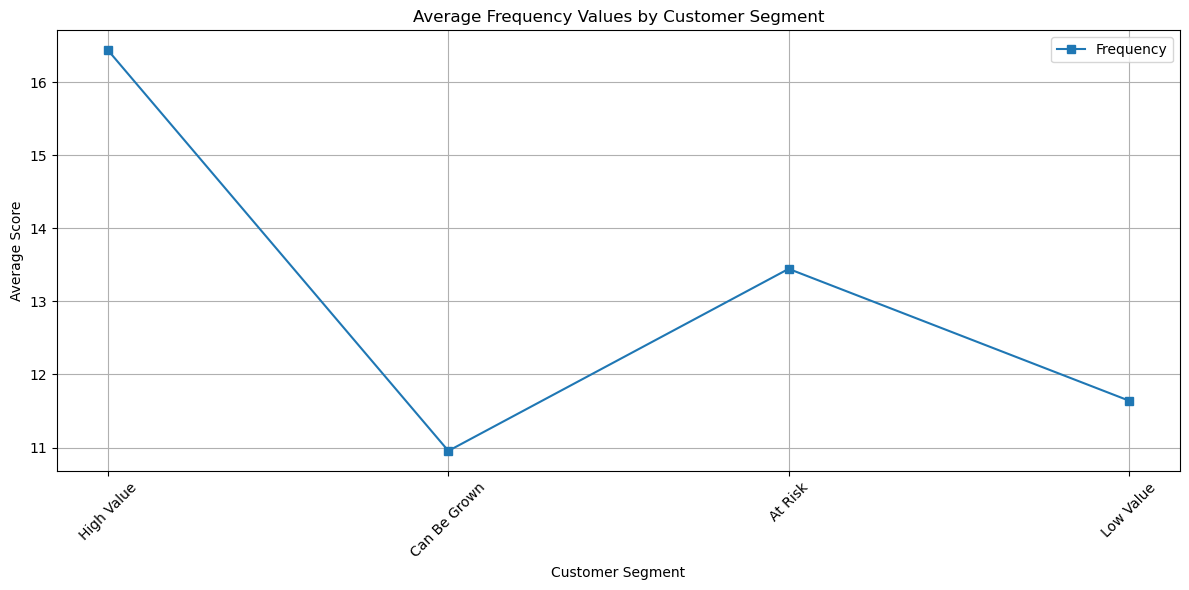

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming rfm dataframe is already defined and the segmentation function has been applied to create 'Refined_Segment'

# Calculate the average RFM values for each segment
segment_grouped = rfm.groupby('Refined_Segment').mean()

# Sort the segments in a meaningful order for display
ordered_segments = ['High Value', 'Can Be Grown', 'At Risk', 'Low Value']
segment_grouped = segment_grouped.reindex(ordered_segments)

# Plot the averages for Recency, Frequency, and Monetary by segment
plt.figure(figsize=(12, 6))
plt.plot(segment_grouped.index, segment_grouped['Frequency'], marker='s', linestyle='-', label='Frequency')

# Customize the plot
plt.title('Average Frequency Values by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Average Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

/var/folders/dx/5nl8g36s7w12fygbr3_npf7c0000gn/T/ipykernel_55146/1453614764.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  segment_grouped = rfm.groupby('Refined_Segment').mean()


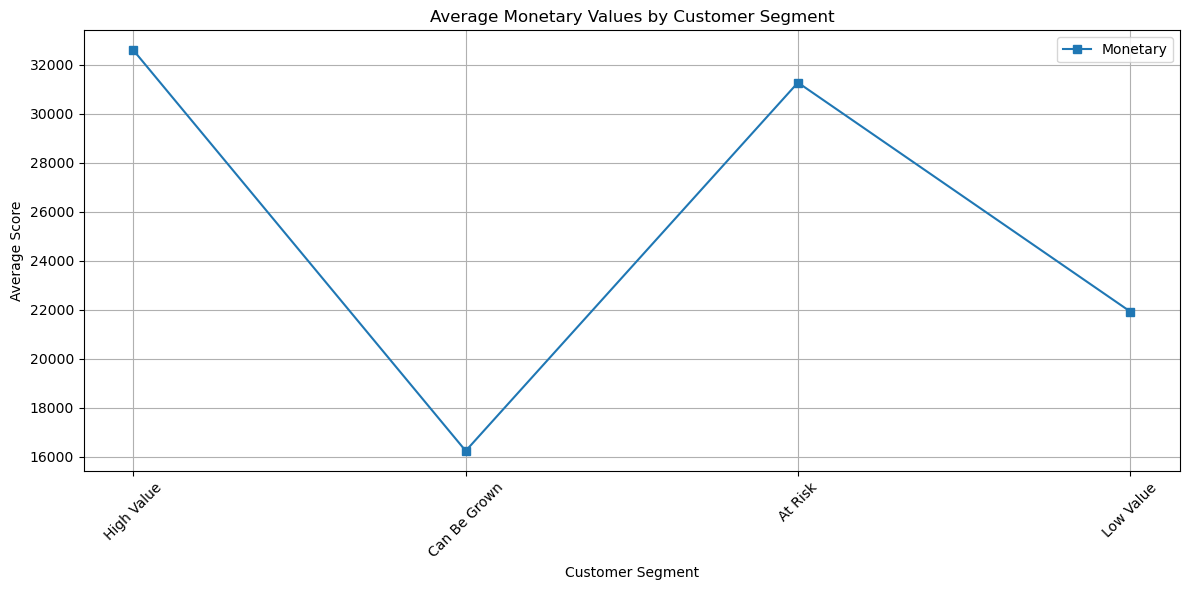

In [41]:
segment_grouped = rfm.groupby('Refined_Segment').mean()

ordered_segments = ['High Value', 'Can Be Grown', 'At Risk', 'Low Value']
segment_grouped = segment_grouped.reindex(ordered_segments)

plt.figure(figsize=(12, 6))
plt.plot(segment_grouped.index, segment_grouped['Monetary'], marker='s', linestyle='-', label='Monetary')

plt.title('Average Monetary Values by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Average Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()